# Convert daily to monthly rainfall 
#### Jose Valles (jose.valles.leon@gmail.com)

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import numpy as np
import calendar

sns.set()

from IPython.display import HTML

In [2]:
def get_seconds_in_month(row):
    year = int(row['year'])
    month = int(row['month'])
    _, num_days = calendar.monthrange(year, month)
    seconds_in_day = 24 * 60 * 60
    return num_days * seconds_in_day


### Importar datos de modelos

Importar datos de precipitación, escorrentia, humedad suelo y Evapotranspiración (potencial y actual)

In [3]:
# Escorrentia
ESCORRENTIA = pd.read_csv('../output_modelo/Escorrentia.csv')
ESCORRENTIA = ESCORRENTIA.rename(columns={'-1': 'year','-1.1':'month'})
ESCORRENTIA['date'] = pd.to_datetime(dict(year=ESCORRENTIA['year'],month=ESCORRENTIA['month'],day=1))
ESCORRENTIA = ESCORRENTIA.set_index('date')
ESCORRENTIA['days_in_month'] = ESCORRENTIA.index.days_in_month

# Precipitación
PRECIP = pd.read_csv('../output_modelo/Pmedias.csv')
PRECIP = PRECIP.rename(columns={'-1': 'year','-1.1':'month'})
PRECIP['date'] = pd.to_datetime(dict(year=PRECIP['year'],month=PRECIP['month'],day=1))

# Evapotranspiración Real
ETR = pd.read_csv('../output_modelo/ETR.csv')
ETR = ETR.rename(columns={'-1': 'year','-1.1':'month'})
ETR['date'] = pd.to_datetime(dict(year=ETR['year'],month=ETR['month'],day=1))

# Humedad Suelo 
SM = pd.read_csv('../output_modelo/HumedadSuelo.csv')
SM = SM.rename(columns={'-1': 'year','-1.1':'month'})
SM['date'] = pd.to_datetime(dict(year=SM['year'],month=SM['month'],day=1))


In [4]:
# Convert 'Year' and 'Month' columns to integers
ESCORRENTIA['year'] = ESCORRENTIA['year'].astype(int)
ESCORRENTIA['month'] = ESCORRENTIA['month'].astype(int)

In [5]:
ESCORRENTIA['seconds_in_month'] = ESCORRENTIA.apply(get_seconds_in_month, axis=1)

Importar codigos de cuenca nivel 2 y 3

In [6]:
CUENCA_NIVEL_3 = pd.read_csv(f'../output_modelo/cuenca_nivel3.csv',index_col="Codigo")
CUENCA_NIVEL_2 = pd.read_csv(f'../output_modelo/cuenca_nivel2.csv',index_col="Codigo")

In [7]:
HTML(ESCORRENTIA.tail(6).to_html(index=False))

year,month,101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,days_in_month,seconds_in_month
2022,12,3.88770,3.89020,2.71840,2.49150,2.04800,2.39700,3.93120,2.53360,2.23180,2.247000,2.303000,2.378000,2.73380,3.01430,2.97750,4.62700,6.32330,6.52480,6.18950,5.78980,4.96420,5.29880,6.281000,6.397000,7.0079,7.31650,7.69270,7.57150,7.13410,7.09920,6.38530,7.07820,7.21560,6.87950,7.09450,7.19250,7.12800,6.77890,6.87280,6.40200,5.81330,4.42790,4.38670,5.2071,1.87810,1.75590,3.9880,3.68460,1.74320,1.58900,2.75350,3.01770,1.421800,1.107900,1.37060,0.053863,0.000953,0.001815,0.000153,1.123200e-04,2.101200e-05,2.853200e-05,2.076200e-05,0.000480,1.076600e-04,3.959000e-05,3.155600e-05,2.629500e-05,3.299900e-05,2.975000e-05,2.098900e-05,2.118100e-05,2.993800e-05,3.271200e-05,4.083100e-05,3.923600e-05,3.905200e-05,3.828300e-05,0.000926,0.000918,0.000827,0.000907,0.000588,0.000449,9.597600e-05,0.000149,3.303400e-05,3.550100e-05,3.366500e-05,6.650400e-05,0.000352,0.000460,0.000266,8.294700e-05,0.000150,0.000146,1.007800e-04,0.087564,0.113720,0.103120,0.083226,0.193500,0.099278,0.623850,0.538240,0.602040,0.482390,0.358180,1.04890,0.819060,0.762750,0.80296,0.87064,0.674810,0.616900,0.712900,0.710470,0.522430,0.519310,0.652330,1.159600,1.39050,2.29340,2.504900,2.556500,2.33400,2.13180,2.694900,2.897600,3.22200,4.15910,4.408500,4.94550,4.973500,5.10970,5.80800,5.83390,5.21800,6.47050,6.88100,4.23340,2.70390,4.44460,4.29210,3.92070,3.68220,3.79750,3.81070,3.8256,3.75120,2.86530,3.11140,2.56140,2.73450,2.76130,3.11650,3.05780,2.04230,2.74660,1.76610,1.55860,1.35940,2.41750,1.71640,2.91430,2.51300,4.93820,2.8631,1.99220,1.59760,1.62300,1.81060,1.90650,2.44400,3.19100,3.34600,4.30670,3.79170,2.83810,3.66660,5.00400,6.6011,6.51410,6.65590,4.188100,4.099200,3.914200,3.893700,4.167500,4.31540,3.93430,3.48450,2.56780,4.355200,4.313400,4.151000,4.40590,4.76180,5.37780,6.33310,5.064100,5.920500,5.737500,6.226700,6.28230,6.186700,6.131500,5.640200,5.954200,5.319800,4.755900,4.050600,3.220500,5.175900,5.15350,3.049200,2.358300,2.630900,3.10620,2.67480,2.89520,2.85010,2.35230,2.450200,2.32050,3.100900,2.247100,2.013600,1.95540,2.18040,1.98100,1.50610,1.18920,0.480810,1.08370,0.054889,0.000935,0.310250,0.000892,0.095518,0.320860,1.12880,0.002872,0.277710,0.459920,2.10230,1.73400,0.126100,0.068388,0.82137,0.028704,0.011638,0.011436,0.007251,1.15180,1.19080,1.11870,0.735300,0.768490,1.11620,0.608100,0.564730,0.370800,0.274560,3.4867,1.22200,0.224290,0.000797,0.351440,0.175640,0.105390,0.000280,0.017021,0.014850,0.004953,1.028500e-04,0.000145,0.001100,0.000903,0.001003,0.001144,0.001093,0.000905,0.000692,0.000222,0.000282,5.606400e-05,6.528800e-05,3.567100e-05,7.209000e-05,0.019159,0.002445,0.056309,1.977900e-05,6.331000e-05,0.038324,31,2678400
2023,1,1.44460,1.44550,1.01010,0.92577,0.76100,0.89067,1.46070,0.94144,0.82929,0.834950,0.855760,0.883610,1.01

### Convertir Escorrentia (mm/month) a Caudal (m3/s)

In [8]:
# Convertir datos de escorrentia a caudal
ESCORRENTIA_SELECTION = ESCORRENTIA.drop(['year','month','days_in_month','seconds_in_month'],axis=1)
CAUDAL = pd.DataFrame(ESCORRENTIA_SELECTION.values*1000*CUENCA_NIVEL_3.values,columns=ESCORRENTIA_SELECTION.columns)
CAUDAL['days_in_month'] = ESCORRENTIA['days_in_month'].values
CAUDAL = CAUDAL.loc[:, CAUDAL.columns != 'days_in_month'].divide(CAUDAL["days_in_month"]*24*3600, axis="index")
# Definir columns de date y año
CAUDAL['date'] = ESCORRENTIA.index.values
CAUDAL = CAUDAL.set_index('date')
CAUDAL['year'] = ESCORRENTIA['year'].values
CAUDAL['month'] = ESCORRENTIA['month'].values

In [9]:
HTML(CAUDAL.tail(6).to_html(index=False))

101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,year,month
1.219261,1.466959,0.825142,0.164649,0.318088,1.320032,3.551935,1.019721,0.049162,0.383393,0.068787,0.214858,0.216385,0.063023,0.332390,2.040206,0.998639,1.154703,1.998924,0.849534,0.411459,1.922952,1.127972,2.992623,1.452130,10.079856,2.148350,2.244538,1.960386,0.691790,0.023840,0.626319,2.877188,0.816787,4.518824,2.019400,2.560161,0.212600,0.369505,0.621461,1.883940,0.593495,2.746601,3.855167,0.243317,0.167828,2.412097,0.884557,0.182234,0.268749,0.813179,0.575734,0.030258,0.239499,1.259351,0.012931,4.625911e-06,0.002112,1.582952e-05,9.770968e-06,7.060484e-08,5.390230e-06,7.805904e-06,1.362830e-05,7.315606e-06,1.463340e-06,1.131039e-06,1.021013e-06,2.427122e-06,2.454730e-06,4.686164e-06,5.535656e-08,2.246691e-06,1.868629e-06,2.789752e-06,2.343847e-07,6.852763e-07,4.545249e-06,2.558421e-05,7.881175e-06,4.662711e-05,3.149549e-05,6.189702e-05,6.441290e-05,2.114167e-06,3.493399e-05,1.332016e-06,6.759823e-07,2.136742e-07,1.315977e-06,5.115646e-05,8.835219e-05,3.533151e-05,3.251731e-06,1.022679e-05,6.114755e-06,4.515233e-06,0.001798,0.002887,0.006353,0.007551,0.061119,0.000741,0.150000,0.013263,0.004720,0.002521,0.004413,0.074798,0.023241,0.046419,0.036574,0.122548,0.039052,0.006219,0.008517,0.016446,0.025747,0.005817,0.018997,0.014720,0.369637,0.011988,0.036474,0.006681,0.754646,0.388410,0.131807,0.027046,0.855302,0.863374,0.064192,2.241576,0.191260,2.623147,0.268889,1.339549,3.767776,0.243997,0.244062,2.958828,0.097923,0.416515,0.410237,0.471351,0.962343,1.288802,0.083942,0.431351,1.107825,0.253538,0.994384,0.019126,0.247069,0.161859,0.657416,0.271713,0.142589,0.190736,0.046157,0.126275,0.357309,0.748248,0.945225,1.558123,0.192341,0.433272,0.487445,0.454463,0.643597,0.970140,2.085462,0.858437,0.986396,0.146540,3.290533,0.418064,0.859305,0.245833,1.384010,1.728159,0.187307,0.014593,0.919460,0.537898,1.692695,0.993749,2.827526,1.513955,1.930201,1.913976,1.602787,2.529068,0.214638,0.193253,0.587376,0.952440,0.627582,0.861364,1.570034,6.740411,0.249782,1.004662,1.731964,1.770884,2.614749,1.973325,0.098973,0.835864,0.826253,5.000229,3.508584,0.349898,1.045461,3.673100,0.753648,0.791559,1.669851,1.244382,1.142462,0.680995,0.012769,0.689425,0.110691,0.224391,2.244865,0.580568,0.312746,0.146743,0.472159,0.359456,0.992483,0.461312,0.086167,0.635233,0.023506,0.000495,0.184060,0.000843,0.059806,0.061215,0.006743,0.003544,0.049665,0.012363,2.161639,0.707610,0.019444,0.006945,0.265571,0.001865,0.003554,0.007549,0.001148,0.115249,0.371680,0.169576,0.011530,0.052220,0.453415,0.083550,0.224340,0.095524,0.023475,0.334559,0.212609,0.045052,0.000118,0.017976,0.045641,0.003148,9.195579e-06,0.003686,0.001769,0.000751,2.265588e-06,4.671498e-06,0.000141,8.528737e-05,0.000114,0.000120,0.000204,0.000226,0.000151,2.325510e-05,3.698710e-05,2.072258e-06,1.657551e-06,1.185304e-06,3.04143

In [10]:
VOLUME = pd.DataFrame(CAUDAL.drop(['year','month'],axis=1))
VOLUME['seconds_in_month'] = ESCORRENTIA['seconds_in_month'].values
VOLUME = VOLUME.loc[:, VOLUME.columns != 'seconds_in_month'].multiply(VOLUME["seconds_in_month"], axis="index")
VOLUME['date'] = CAUDAL.index.values
VOLUME = VOLUME.set_index('date')
VOLUME['year'] = CAUDAL['year'].values
VOLUME['month'] = CAUDAL['month'].values

In [11]:
HTML(VOLUME.tail(6).to_html(index=False))

101,102,103,105,106,107,108,109,110,111,112,114,115,116,117,119,120,123,125,128,130,131,132,133,134,135,136,137,138,139,140,142,146,148,150,155,158,160,163,165,167,168,170,171,172,173,174,175,176,177,178,179,180,183,186,189,190,193,196,199,201,204,208,210,211,212,213,214,215,216,217,220,221,222,223,224,225,226,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,260,262,264,266,268,270,274,275,276,277,279,280,281,282,283,284,285,286,287,288,289,290,293,294,295,297,298,300,301,305,306,310,312,315,316,318,320,325,330,333,334,335,338,406,407,410,411,412,413,414,415,416,417,418,419,420,422,424,426,428,430,431,432,433,434,435,436,437,438,440,441,442,443,444,445,446,447,448,449,450,452,453,454,455,457,458,459,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524,526,530,532,534,536,538,540,541,542,543,544,545,546,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,575,580,581,582,583,584,585,586,587,588,589,600,601,602,603,604,605,606,607,608,609,610,611,612,613,615,616,618,620,625,630,635,640,645,650,651,652,653,654,655,656,657,658,660,661,662,666,670,673,677,680,683,687,year,month
3265668.0,3929102.0,2210059.20,440995.50,851968.00,3535575.00,9513504.0,2731220.80,131676.20,1026879.000,184240.00,575476.000,579565.60,168800.80,890272.50,5464487.00,2674755.90,3092755.20,5353917.5,2275391.40,1102052.40,5150433.60,3021161.000,8015441.000,3889384.5,26997885.0,5754139.60,6011771.00,5250697.60,1852891.20,63853.0,1677533.40,7706260.80,2187681.0,12103217.00,5408760.00,6857136.00,569427.60,989683.20,1664520.0,5045944.40,1589616.10,7356495.90,10325679.3,651700.70,449510.40,6460560.0,2369197.80,488096.0,719817.00,2178018.50,1542044.70,81042.600,641474.100,3373046.60,34633.9090,12.390040,5657.922800,42.397780,26.170560,0.189108,14.437192,20.907334,36.502040,19.594120,3.919410,3.029376,2.734680,6.500803,6.574750,12.551422,0.148267,6.017538,5.004936,7.472073,0.627776,1.835444,12.173994,68.524740,21.108940,124.886060,84.357510,165.784980,172.523520,5.662584,93.567210,3.567672,1.810551,0.572305,3.524712,137.017470,236.642500,94.631920,8.709435,27.391440,16.377760,12.093600,4816.02000,7732.96000,17014.80000,20223.91800,163701.0000,1985.5600,401759.400,35523.840,12642.8400,6753.4600,11819.9400,200339.90,62248.5600,124328.2500,97961.12,328231.28,104595.550,16656.3000,22812.800,44049.1400,68960.7600,15579.300,50881.7400,39426.400,990036.00,32107.60,97691.100,17895.500,2021244.00,1040318.40,353031.900,72440.000,2290842.00,2312459.6,171931.500,6003837.00,512270.500,7025837.50,720192.00,3587848.50,10091612.0,653520.50,653695.00,7924924.80,262278.30,1115594.60,1098777.60,1262465.40,2577540.0,3451927.50,224831.30,1155331.2,2967199.20,679076.10,2663358.40,51228.0,661749.0,433524.10,1760822.50,727756.40,381910.10,510867.60,123627.0,338216.20,957017.60,2004107.50,2531690.00,4173277.60,515165.00,1160477.00,1305573.6,1217234.20,1723810.40,2598423.00,5585701.00,2299239.00,2641964.00,392493.00,8813364.00,1119742.0,2301561.90,658439.2,3706932.60,4628700.00,501683.6,39084.60,2462683.0,1440706.400,4533715.200,2661656.00,7573246.500,4054977.500,5169849.20,5126392.90,4292904.00,6773856.40,574886.40,517608.00,1573229.000,2551016.10,1680915.40,2307076.20,4205178.40,18053516.500,669016.500,2690887.500,4638891.50,4743136.50,7003344.400,5285353.000,265089.400,2238779.200,2213036.800,13392614.400,9397392.00,937165.500,2800161.900,9838031.50,2018570.400,2120111.700,4472530.0,3332952.60,3059971.20,1823976.0,34201.20,1846555.5,296474.200,601009.50,6012645.100,1554993.200,837657.600,393035.40,1264632.0,962766.00,2658266.50,1235578.80,230788.8,1701409.0,6.295768e+04,1.325504e+03,492987.250,2.258904e+03,160183.686,163959.460,18060.80,9491.299000,133023.090,33114.240,5789734.20,1895262.00,52079.300,18601.53600,711306.42,4994.4960,9519.88400,2.021885e+04,3074.254400,308682.40,995508.80,454192.20,30882.6000,139865.180,1214425.60,223780.8000,600872.7200,255852.000,62874.2400,896081.9,56

In [12]:
VOLUME

,101,102,103,105,106,107,108,109,110,111,...,662,666,670,673,677,680,683,687,year,month
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,9311400.0,10660550.0,7508542.80,1498871.40,3405792.00,13171602.50,22495352.0,8685769.40,437821.30,3507840.600,...,7.398570e+05,9.480813e+05,3.604690e+05,3.524808e+05,6.605506e+05,16748.200000,2.007408e+05,6.164570e+05,1980,1
1980-02-01,3459876.0,3961119.0,4031016.60,3105642.00,2779088.00,7232367.50,11128854.0,7413621.60,914264.00,3550981.400,...,2.749121e+05,3.522888e+05,1.445144e+05,1.327200e+05,2.860906e+05,6223.200000,7.459200e+04,2.547968e+05,1980,2
1980-03-01,20833680.0,6057475.0,7089278.70,3293970.00,2476864.00,9058122.50,25136540.0,6683600.00,580636.70,2644613.300,...,1.021542e+05,1.308992e+05,5.996350e+04,5.037480e+04,1.296785e+05,2312.400000,2.771520e+04,1.097568e+05,1980,3
1980-04-01,79309440.0,40042460.0,8899911.00,1851774.00,1318886.40,7647727.50,28860920.0,3560957.40,259570.50,1238241.500,...,1.587404e+06,3.612610e+06,1.786951e+06,1.648248e+06,3.270916e+06,30488.000000,4.854720e+05,2.697892e+06,1980,4
1980-05-01,40325880.0,35918630.0,17789253.00,3060861.00,2289206.40,20862400.00,51938040.0,3693228.00,182935.40,823696.800,...,5.108155e+06,7.519133e+06,3.054075e+06,2.940420e+06,5.609395e+06,110096.000000,1.422072e+06,5.093050e+06,1980,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,1213464.0,1459955.0,821211.30,163861.29,316576.00,1313738.25,3534894.0,1014872.32,48928.11,381572.150,...,1.179606e+00,3.026931e+00,3.061170e+02,3.815574e+01,1.652917e+03,0.014699,5.645760e-01,1.053760e+03,2023,1
2023-02-01,450886.8,542481.1,305135.16,60888.00,117632.32,488151.25,1313527.6,377105.96,18180.85,141784.250,...,4.383250e-01,1.124734e+00,1.137479e+02,1.417794e+01,6.141855e+02,0.005462,2.097864e-01,3.915636e+02,2023,2
2023-03-01,17807160.0,10290890.0,36294759.00,10989576.00,12835264.00,50477450.00,26196500.0,769810.58,59643.10,52682.960,...,1.628700e-01,4.179305e-01,4.226513e+01,5.268060e+00,2.282152e+02,0.002029,7.795200e-02,1.454988e+02,2023,3


## Normales hidrologicas para cuencas nivel 2

Seleccionar el codigo de cuenca nivel 2 para el analisis

In [13]:
# Seleccionar cuenca nivel 2
codcuenca_n2 = 61
# Buscar columnas que empiezan con el codigo de cuenca nivel 2
filter_col = [col for col in CAUDAL if col.startswith(str(codcuenca_n2))]

# Obtener variables en base a los codigos de cuenca nivel 3 que corresponden a las cuencas nivel 2
CAUDAL_SELECTED = CAUDAL[filter_col]
PRECIP_SELECTED = PRECIP[filter_col]
ETR_SELECTED = ETR[filter_col]
SM_SELECTED = SM[filter_col]
ESCORRENTIA_SELECTED = ESCORRENTIA[filter_col]
VOLUME_SELECTED = VOLUME[filter_col]

In [14]:
VOLUME_SELECTED = VOLUME_SELECTED.drop(columns=['618']) # Remove the subbasin below Paso Severino IF the basin_nivel_2 = 61
HTML(VOLUME_SELECTED.tail(6).to_html(index=False))

610,611,612,613,615,616
896081.9,569452.00,120668.020,316.49634,48147.280,122245.440
332969.2,211591.96,44837.996,117.60331,17890.830,45423.744
123719.8,78623.52,16660.784,43.69779,6647.788,16878.000
3182431.0,2211309.80,1234172.000,423360.80000,10609.006,87640.320
1864740.6,1669025.60,1048723.400,386864.59000,8869.243,81501.600
692897.7,620152.80,389684.160,143749.73000,3295.672,30283.656


### Agregar las variables para las cuencas nivel 2 seleccionada

In [15]:
# Caudal
CAUDAL_N2 = pd.DataFrame()
CAUDAL_N2['year'] = CAUDAL['year']
CAUDAL_N2['month'] = CAUDAL['month']
CAUDAL_N2['discharge'] = CAUDAL_SELECTED.sum(axis=1)

CAUDAL_N2['date'] = pd.to_datetime(dict(year=CAUDAL_N2['year'],month=CAUDAL_N2['month'],day=1))
CAUDAL_N2 = CAUDAL_N2.set_index('date')

# Precip
PRECIP_N2 = pd.DataFrame()
PRECIP_N2['year'] = PRECIP['year']
PRECIP_N2['month'] = PRECIP['month']
PRECIP_N2['precip'] = PRECIP_SELECTED.mean(axis=1)

PRECIP_N2['date'] = pd.to_datetime(dict(year=PRECIP_N2['year'],month=PRECIP_N2['month'],day=1))
PRECIP_N2 = PRECIP_N2.set_index('date')

# Escorrentia
ESCORRENTIA_N2 = pd.DataFrame()
ESCORRENTIA_N2['year'] = ESCORRENTIA['year']
ESCORRENTIA_N2['month'] = ESCORRENTIA['month']
ESCORRENTIA_N2['runoff'] = ESCORRENTIA_SELECTED.mean(axis=1)

ESCORRENTIA_N2['date'] = pd.to_datetime(dict(year=ESCORRENTIA_N2['year'],month=ESCORRENTIA_N2['month'],day=1))
ESCORRENTIA_N2 = ESCORRENTIA_N2.set_index('date')

# ETR
ETR_N2 = pd.DataFrame()
ETR_N2['year'] = ETR['year']
ETR_N2['month'] = ETR['month']
ETR_N2['etr'] = ETR_SELECTED.mean(axis=1)

ETR_N2['date'] = pd.to_datetime(dict(year=ETR_N2['year'],month=ETR_N2['month'],day=1))
ETR_N2 = ETR_N2.set_index('date')

# Humedad Suelo
SM_N2 = pd.DataFrame()
SM_N2['year'] = SM['year']
SM_N2['month'] = SM['month']
SM_N2['soilmoisture'] = SM_SELECTED.mean(axis=1)

SM_N2['date'] = pd.to_datetime(dict(year=SM_N2['year'],month=SM_N2['month'],day=1))
SM_N2 = SM_N2.set_index('date')

# Volumen
VOLUME_N2 = pd.DataFrame()
VOLUME_N2['year'] = VOLUME['year']
VOLUME_N2['month'] = VOLUME['month']
VOLUME_N2['volume'] = VOLUME_SELECTED.sum(axis=1) / 1e6

VOLUME_N2['date'] = pd.to_datetime(dict(year=VOLUME_N2['year'],month=VOLUME_N2['month'],day=1))
VOLUME_N2 = VOLUME_N2.set_index('date')


In [16]:
HTML(VOLUME_N2.tail(10).to_html(index=True))

,year,month,volume
date,,,
2022-08-01,2022,8,22.776811
2022-09-01,2022,9,11.479317
2022-10-01,2022,10,7.083933
2022-11-01,2022,11,4.148993
2022-12-01,2022,12,1.756911
2023-01-01,2023,1,0.652831
2023-02-01,2023,2,0.242574
2023-03-01,2023,3,7.149523
2023-04-01,2023,4,5.059725


In [17]:
# SM_N2.to_clipboard()

In [18]:
VOLUME_N2.drop(columns={'year','month'}).rename(columns={'volume': 'Volumen'}).to_csv(f'codcuenca_{codcuenca_n2}.csv',date_format='%d/%m/%Y')

In [19]:
# CAUDAL_N2_PLOT = CAUDAL_N2
VOLUME_N2_PLOT = VOLUME_N2.loc['2020-01-01':'2024-05-01']

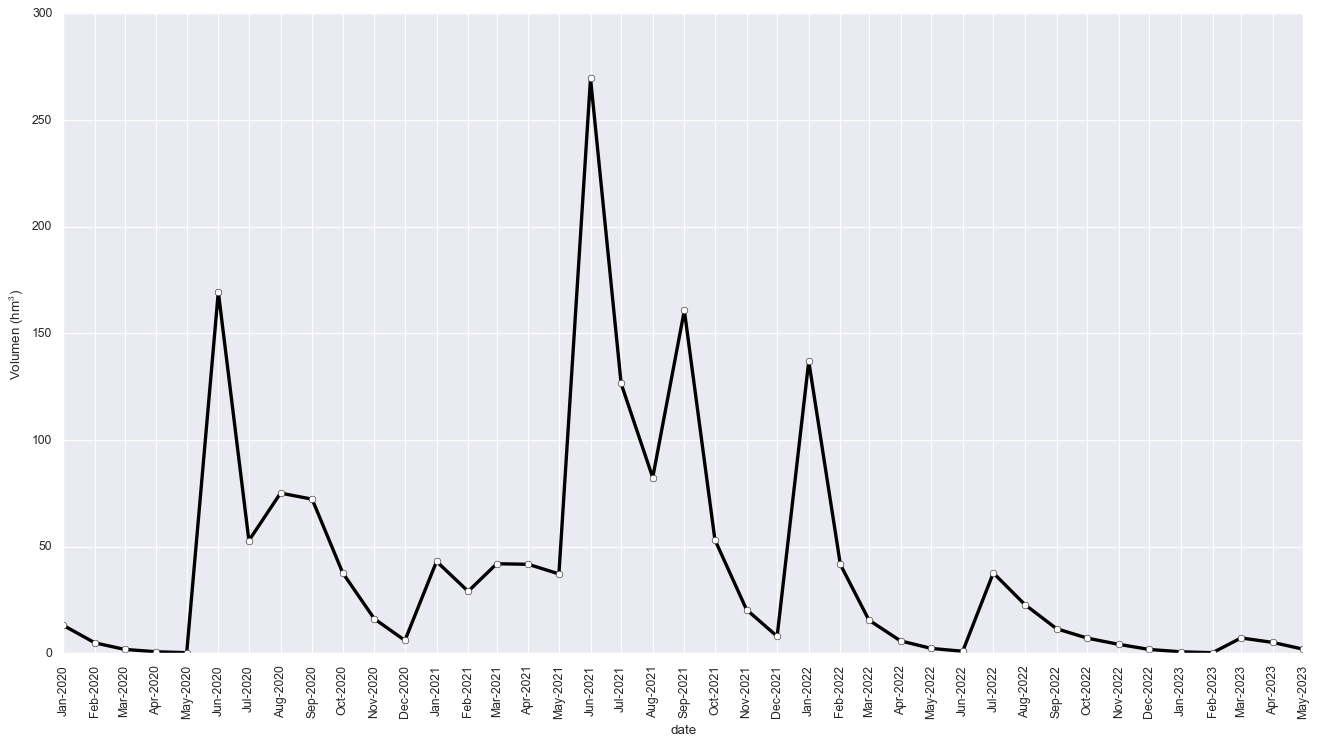

In [20]:
import matplotlib.dates as mdates

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(VOLUME_N2_PLOT.index,VOLUME_N2_PLOT['volume'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')

# ax1 = VOLUME_N2_PLOT['volume'].plot(figsize=(20, 10),color='black',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k');
ax1.set_xlabel('date');
# ax1.set_ylabel('Caudal (m$^3$/s)');
ax1.set_ylabel('Volumen (hm$^3$)');

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# ax1.set_ylim(0,50)
plt.xticks(rotation=90);   #optional formatting 

In [21]:
# VOLUME_N2_PLOT.to_clipboard()

### Seleccionar el periodo de simulación para calcular las normales

En esta parte utilizaremos el periodo 1981-2010

In [22]:
year_start = 1981
year_end = 2010
# Caudal
CAUDAL_N2_REF = CAUDAL_N2[(CAUDAL_N2['year'] >= year_start) & (CAUDAL_N2['year'] <= year_end)]

# Escorrentia
ESCORRENTIA_N2_REF = ESCORRENTIA_N2[(ESCORRENTIA_N2['year'] >= year_start) & (ESCORRENTIA_N2['year'] <= year_end)]

# Precip
PRECIP_N2_REF = PRECIP_N2[(PRECIP_N2['year'] >= year_start) & (PRECIP_N2['year'] <= year_end)]

# ETR
ETR_N2_REF = ETR_N2[(ETR_N2['year'] >= year_start) & (ETR_N2['year'] <= year_end)]

# Humedad Suelo
SM_N2_REF = SM_N2[(SM_N2['year'] >= year_start) & (SM_N2['year'] <= year_end)]

# Volumen
VOLUME_N2_REF = VOLUME_N2[(VOLUME_N2['year'] >= year_start) & (VOLUME_N2['year'] <= year_end)]

Calcular las normales correspondiente al periodo de referencia

In [23]:
# Caudal
CAUDAL_N2_AVERAGE = CAUDAL_N2_REF.groupby(CAUDAL_N2_REF.month).mean()
CAUDAL_N2_AVERAGE = CAUDAL_N2_AVERAGE.reindex(columns=['discharge'])

# Escorrentia
ESCORRENTIA_N2_AVERAGE = ESCORRENTIA_N2_REF.groupby(ESCORRENTIA_N2_REF.month).mean()
ESCORRENTIA_N2_AVERAGE = ESCORRENTIA_N2_AVERAGE.reindex(columns=['runoff'])

# Precip
PRECIP_N2_AVERAGE = PRECIP_N2_REF.groupby(PRECIP_N2_REF.month).mean()
PRECIP_N2_AVERAGE = PRECIP_N2_AVERAGE.reindex(columns=['precip'])

# ETR
ETR_N2_AVERAGE = ETR_N2_REF.groupby(ETR_N2_REF.month).mean()
ETR_N2_AVERAGE = ETR_N2_AVERAGE.reindex(columns=['etr'])

# Humedad Suelo
SM_N2_AVERAGE = SM_N2_REF.groupby(SM_N2_REF.month).mean()
SM_N2_AVERAGE = SM_N2_AVERAGE.reindex(columns=['soilmoisture'])

# Volumen
VOLUME_N2_AVERAGE = VOLUME_N2_REF.groupby(VOLUME_N2_REF.month).mean()
VOLUME_N2_AVERAGE = VOLUME_N2_AVERAGE.reindex(columns=['volume'])


In [24]:
HTML(VOLUME_N2_AVERAGE.to_html())

,volume
month,
1,24.759830
2,40.537663
3,67.143981
4,50.748676
5,81.534060
6,119.230474
7,129.522200
8,132.684091
9,112.894564


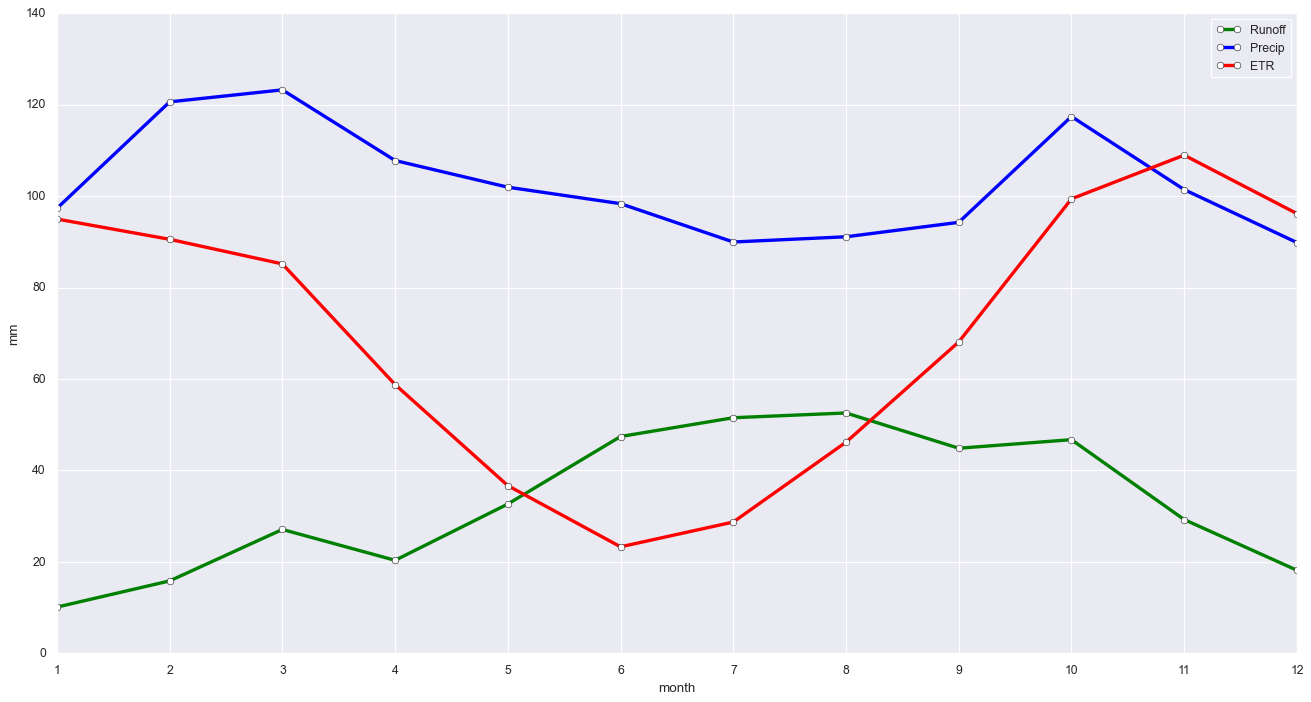

In [25]:
ax2 = ESCORRENTIA_N2_AVERAGE['runoff'].plot(figsize=(20, 10),color='green',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='Runoff');
ax2 = PRECIP_N2_AVERAGE['precip'].plot(figsize=(20, 10),color='blue',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='Precip');
ax2 = ETR_N2_AVERAGE['etr'].plot(figsize=(20, 10),color='red',linestyle='-', linewidth=3, marker='o', mfc='white', mec='k',label='ETR');
ax2.set_xlim(1,12)
ax2.set_xlabel('month');
ax2.set_ylabel('mm');
ax2.set_xticks(np.arange(1,13,1));
ax2.legend();

In [26]:
# ESCORRENTIA_N2_AVERAGE.to_clipboard()

In [27]:
variable_basin = [PRECIP_N2.precip, ETR_N2.etr, SM_N2.soilmoisture, ESCORRENTIA_N2.runoff, CAUDAL_N2.discharge, VOLUME_N2.volume]
variable_basin = pd.concat(variable_basin,axis=1)

In [28]:
HTML(variable_basin.tail(12).to_html(index=True))

,precip,etr,soilmoisture,runoff,discharge,volume
date,,,,,,
2022-06-01,5.195657,15.591857,57.470000,0.373750,0.357227,0.906427
2022-07-01,96.224857,21.539000,106.721571,15.655678,14.049967,37.624185
2022-08-01,33.040429,37.461571,95.398000,9.349860,8.576951,22.776811
2022-09-01,18.444714,63.994714,49.847571,4.746348,4.492150,11.479317
2022-10-01,63.781714,92.789286,18.030143,3.050081,2.667636,7.083933
2022-11-01,65.697714,83.197000,0.000000,1.831272,1.609445,4.148993
2022-12-01,18.905286,18.905286,0.000000,0.795180,0.659103,1.756911
2023-01-01,7.621229,7.621229,0.000000,0.295473,0.244909,0.652831
2023-02-01,53.566143,53.566143,0.000000,0.109789,0.100751,0.242574


In [29]:
variable_basin.to_clipboard()

### Seleccionar variable para calcular percentil 


In [30]:
VARIABLE_MENSUAL = VOLUME_N2
VARIABLE_AVERAGE = VOLUME_N2_AVERAGE
VARIABLE = VARIABLE_MENSUAL.columns[2]
print(VARIABLE)

volume


In [31]:
# create empty columns in the dataframe
VARIABLE_MENSUAL['mean'] = np.nan
VARIABLE_MENSUAL['average_percentage'] = np.nan
VARIABLE_MENSUAL['rank_average'] = np.nan
VARIABLE_MENSUAL['non_missing'] = np.nan


for i in range(len(VARIABLE_MENSUAL)):
    # Extract the current month 
    m = VARIABLE_MENSUAL.month[i]
    # Extract the current year
    y = VARIABLE_MENSUAL.year[i]
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'rank_average']  = VARIABLE_MENSUAL.query('month==@m')[VARIABLE].rank()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'non_missing']  = VARIABLE_MENSUAL.query('month==@m')[VARIABLE].notnull().sum()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'mean'] = VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()
    VARIABLE_MENSUAL.loc[VARIABLE_MENSUAL.eval('month==@m & year==@y'),'average_percentage'] = (VARIABLE_MENSUAL[VARIABLE][i] - VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()) / VARIABLE_AVERAGE.query('month == @m')[VARIABLE].item()
    
    

In [32]:
VARIABLE_MENSUAL

,year,month,volume,mean,average_percentage,rank_average,non_missing
date,,,,,,,
1980-01-01,1980,1,18.992537,24.759830,-0.232929,24.0,44.0
1980-02-01,1980,2,427.123930,40.537663,9.536472,44.0,44.0
1980-03-01,1980,3,127.774537,67.143981,0.902993,41.0,44.0
1980-04-01,1980,4,100.142969,50.748676,0.973312,39.0,44.0
1980-05-01,1980,5,189.198702,81.534060,1.320487,40.0,44.0
...,...,...,...,...,...,...,...
2023-01-01,2023,1,0.652831,24.759830,-0.973633,3.0,44.0
2023-02-01,2023,2,0.242574,40.537663,-0.994016,2.0,44.0
2023-03-01,2023,3,7.149523,67.143981,-0.893520,22.0,44.0


### Calculate the percentile using Weibull formula

Calculate the percentile using this formula

$$
\ percentile = \frac{i}{N+1}
$$ 


where _i_ is the rank of the current month and _N_ is the number of months in the period of record 

In [33]:
VARIABLE_MENSUAL['percentile'] = VARIABLE_MENSUAL['rank_average']/(VARIABLE_MENSUAL['non_missing']+1)

### Assign the percentile to a category

| Category | Percentile Range |
| :- | :-: |
| High flow | 0.870000 - 1.000000 |
| Above normal | 0.720000 - 0.869999 |
| Normal range | 0.280000 - 0.719999 |
| Below normal | 0.130000 - 0.279999 |
| Low flow | 0.000000 - 0.129999 |

In [34]:
criteria = [VARIABLE_MENSUAL['percentile'].between(0.95,1.00),
            VARIABLE_MENSUAL['percentile'].between(0.87,0.95),
            VARIABLE_MENSUAL['percentile'].between(0.72,0.87),
            VARIABLE_MENSUAL['percentile'].between(0.28,0.72),
            VARIABLE_MENSUAL['percentile'].between(0.13,0.28),
            VARIABLE_MENSUAL['percentile'].between(0.05,0.13),
            VARIABLE_MENSUAL['percentile'].between(0.00,0.05)]

values = ['Exceptionally high flow','Notably high flow','Above normal','Normal range','Below normal','Notably low flow','Exceptionally low flow']

VARIABLE_MENSUAL['percentile_range'] = np.select(criteria,values,None)

In [35]:
HTML(VARIABLE_MENSUAL.tail(12).to_html())

,year,month,volume,mean,average_percentage,rank_average,non_missing,percentile,percentile_range
date,,,,,,,,,
2022-06-01,2022,6,0.906427,119.230474,-0.992398,5.0,43.0,0.113636,Notably low flow
2022-07-01,2022,7,37.624185,129.522200,-0.709516,11.0,43.0,0.250000,Below normal
2022-08-01,2022,8,22.776811,132.684091,-0.828338,4.0,43.0,0.090909,Notably low flow
2022-09-01,2022,9,11.479317,112.894564,-0.898318,3.0,43.0,0.068182,Notably low flow
2022-10-01,2022,10,7.083933,117.417271,-0.939669,2.0,43.0,0.045455,Exceptionally low flow
2022-11-01,2022,11,4.148993,73.393016,-0.943469,2.0,43.0,0.045455,Exceptionally low flow
2022-12-01,2022,12,1.756911,44.915945,-0.960884,3.0,43.0,0.068182,Notably low flow
2023-01-01,2023,1,0.652831,24.759830,-0.973633,3.0,44.0,0.066667,Notably low flow
2023-02-01,2023,2,0.242574,40.537663,-0.994016,2.0,44.0,0.044444,Exceptionally low flow


In [36]:
# VARIABLE_MENSUAL_PLOT = VARIABLE_MENSUAL
VARIABLE_MENSUAL_PLOT = VARIABLE_MENSUAL.loc['2019-04-01':'2023-05-01']

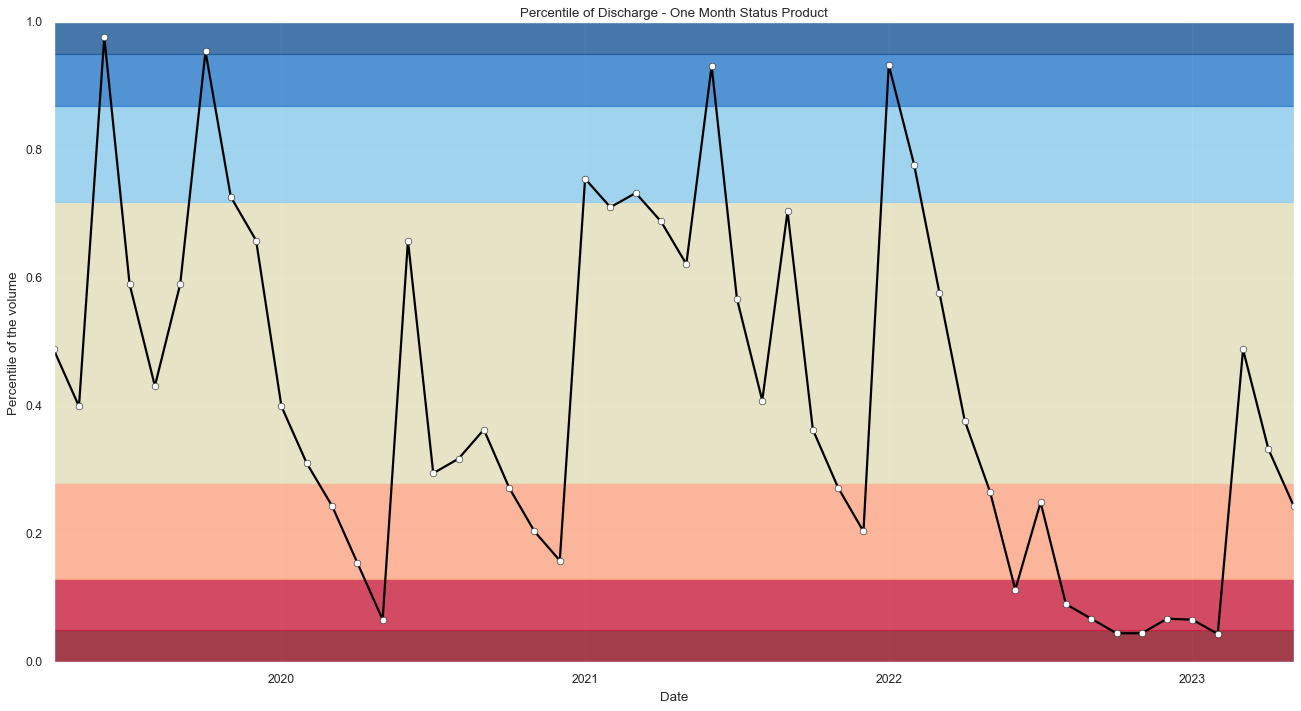

In [37]:
ax = VARIABLE_MENSUAL_PLOT['percentile'].plot(figsize=(20, 10),color='black',linestyle='-', linewidth=2, marker='o', mfc='white', mec='k')
ax.axhspan(0.0, 0.05, color='#901222',alpha=0.8)
ax.axhspan(0.05, 0.13, color='#CD233F',alpha=0.8)
ax.axhspan(0.13, 0.28, color='#FFA885',alpha=0.8)
ax.axhspan(0.28, 0.72, color='#E7E2BC',alpha=0.8)
ax.axhspan(0.72, 0.87, color='#8ECEEE',alpha=0.8)
ax.axhspan(0.87, 0.95, color='#2C7DCD',alpha=0.8)
ax.axhspan(0.95, 1.00, color='#1d5b9a',alpha=0.8)
ax.set_xlim([VARIABLE_MENSUAL_PLOT.index[0],VARIABLE_MENSUAL_PLOT.index[-1]])
ax.set_ylim([0, 1])
ax.set_xlabel('Date')
ax.set_ylabel(f'Percentile of the {VARIABLE}')
ax.set_title('Percentile of Discharge - One Month Status Product');